In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import sys
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np

In [2]:
np.random.seed(2022)
torch.manual_seed(2022)

In [3]:
def softmax(X):
    '''
    X is the input 
    Please compute its softmax outputs
    '''
    # ===============
    # todo: 不调用torch的softmax，手写softmax函数，并返回
#     X_exp = X.exp()
#     partition = X_exp.sum(dim=1, keepdim=True)
#     return X_exp / partition
    
    max_vals = torch.max(X, dim=1, keepdim=True)[0]
    exp_X = torch.exp(X - max_vals)
    softmax_vals = exp_X / torch.sum(exp_X, dim=1, keepdim=True)
    return softmax_vals
    
    # ===============

In [23]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(SoftmaxRegression, self).__init__()
        
        self.linear = nn.Linear(num_inputs, num_outputs, dtype=torch.float64)
        
        nn.init.normal_(self.linear.weight, mean=0, std=0.01)  # 初始化权重：均值为0，标准差为0.01的正态分布
        nn.init.constant_(self.linear.bias, val=0)             # 初始化偏置：常数0

        self.lr = 0.01                  # 学习率
        self.num_classes = num_outputs  # 输出类别的数量

    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))  # 线性变换 
#         y = softmax(y)                           # 进行softmax操作
        return y

    def manual_backward(self, X, y, y_hat):
        '''
        X is the input feature;
        y is the ground truth label;
        y_hat is the predicted label.
        Please update self.linear.weight and self.linear.bias
        '''
        with torch.no_grad():
            # ==============
            #  todo: 将automatic_update设为False，不调用torch的自动更新，手动完成梯度下降法优化'''
            y_onehot = torch.nn.functional.one_hot(y.long(), self.num_classes)
            delta_w = - torch.matmul(torch.t(X), (y_hat - y_onehot))/y.size(0)
            self.linear.weight += self.lr * torch.t(delta_w)
            delta_b = - torch.sum((y_hat - y_onehot), dim=0)/y.size(0)
            self.linear.bias += self.lr * delta_b
#             num_samples = X.size(0)
#             batch_size = 4
#             # 打乱数据顺序
#             perm = torch.randperm(num_samples)
#             X_shuffled = X[perm]
#             y_shuffled = y[perm]
#             y_hat_shuffled = y_hat[perm]
#             num_batches = num_samples // batch_size
#             for i in range(num_batches):
#                 start_idx = i * batch_size
#                 end_idx = (i + 1) * batch_size

#                 X_batch = X_shuffled[start_idx:end_idx]
#                 y_batch = y_shuffled[start_idx:end_idx]
#                 y_hat_batch = y_hat_shuffled[start_idx:end_idx]

#                 batch_size = y_batch.size(0)
#                 y_one_hot = torch.zeros(batch_size, self.num_classes)
#                 y_one_hot.scatter_(1, y_batch.unsqueeze(1).long(), 1)

#                 # 计算梯度
#                 delta_w = torch.matmul(X_batch.t(), y_hat_batch - y_one_hot) / batch_size
#                 delta_b = torch.sum(y_hat_batch - y_one_hot, dim=0) / batch_size

#                 # 更新参数
#                 self.linear.weight -= self.lr * delta_w.t()
#                 self.linear.bias -= self.lr * delta_b
            
            
            # ===============
            

In [24]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [25]:
def train_model(train_set, automatic_update=False):
    
    train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)  # 加载数据
    
    model = SoftmaxRegression(2, 3)                           # softmax回归模型
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)   # 随机梯度下降（SGD）优化器
    loss_func = nn.CrossEntropyLoss()                         # 交叉熵损失函数

    num_epochs = 20
    animation_fram = []
    
    for epoch in range(1, num_epochs + 1):
        train_l_sum, train_acc_sum, n = 0., 0., 0
        for Xy in train_dataloader:
            Xy = Xy.squeeze(1)
            X, y = Xy[:, :-1], Xy[:, -1]
            y_hat = model(X).squeeze(1)               # 模型预测
            loss = loss_func(y_hat, y.long()).sum()   # 计算损失

            if automatic_update:  # 是否使用自动更新梯度
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                model.manual_backward(X, y, y_hat)   # 手动反向传播和梯度更新

            train_l_sum += loss.item()                                        # 训练损失总和 
            train_acc_sum += (y_hat.argmax(dim=1) == y).float().sum().item()  # 训练准确率总和
            n += y.shape[0]                                                   # 样本数量
            
            # 模型的权重、偏置和损失值
            animation_fram.append((model.linear.weight.detach().numpy()[0, 0], \
                                   model.linear.weight.detach().numpy()[0, 1], \
                                   model.linear.bias.detach().numpy(), loss.detach().numpy()))

        print('epoch %d, loss %.4f, train acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n))
        # test_acc = evaluate_accuracy(test_iter, model)
        # print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
        #       % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

    return model

In [26]:
def load_data(filename):
    """载入数据。"""
    xys = []
    with open(filename, 'r') as f:
        for line in f:
            xys.append(line.strip().split())

    if 'train' in filename:
        C1 = [list(map(float, x)) for x in xys if float(list(x)[2]) == 0]
        C2 = [list(map(float, x)) for x in xys if float(list(x)[2]) == 1]
        C3 = [list(map(float, x)) for x in xys if float(list(x)[2]) == 2]
        return torch.tensor(C1, dtype=torch.float64), torch.tensor(C2, dtype=torch.float64), torch.tensor(C3, dtype=torch.float64)
    else:
        xs = [list(map(float, x)) for x in xys]
        return torch.tensor(xs, dtype=torch.float64), None

In [27]:
def zip_fun():
    path=os.getcwd()
    newpath=path+"/output/"
    os.chdir(newpath)
    os.system('zip predict.zip predict.npy')
    os.chdir(path)

epoch 2, loss 0.0192, train acc 0.342
epoch 3, loss 0.0185, train acc 0.423
epoch 4, loss 0.0182, train acc 0.676
epoch 5, loss 0.0175, train acc 0.712
epoch 6, loss 0.0173, train acc 0.806
epoch 7, loss 0.0170, train acc 0.887
epoch 8, loss 0.0166, train acc 0.829
epoch 9, loss 0.0165, train acc 0.887
epoch 10, loss 0.0164, train acc 0.878
epoch 11, loss 0.0162, train acc 0.878
epoch 12, loss 0.0160, train acc 0.887
epoch 13, loss 0.0160, train acc 0.878
epoch 14, loss 0.0158, train acc 0.896
epoch 15, loss 0.0158, train acc 0.869
epoch 16, loss 0.0159, train acc 0.847
epoch 17, loss 0.0158, train acc 0.905
epoch 18, loss 0.0156, train acc 0.919
epoch 19, loss 0.0156, train acc 0.887
epoch 20, loss 0.0155, train acc 0.887
epoch 21, loss 0.0156, train acc 0.887
(100, 100)


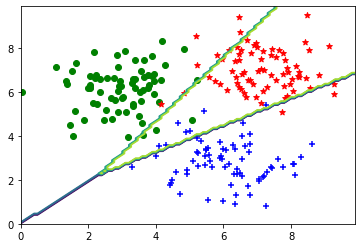

In [28]:
if __name__ == '__main__':
    train_file = './input/train.txt'
    test_file = './input/test_X.txt'
    
    # load data
    C1, C2, C3 = load_data(train_file)
    C, _ = load_data(test_file)

    train_set = np.concatenate((C1, C2, C3), axis=0)
    test_dataloader = DataLoader(C, batch_size=10000, shuffle=False)

    # train model using data set and output animation frame
    my_model = train_model(train_set)

    test_set = next(iter(test_dataloader)).squeeze(1)
    Z = my_model(test_set).detach().numpy()
    preds = np.argmax(Z, axis=1)
    np.save('./output/predict.npy', preds)

    # generate animation
    plt.scatter(np.array(C1[:, 0]), np.array(C1[:, 1]), c='b', marker='+')
    plt.scatter(np.array(C2[:, 0]), np.array(C2[:, 1]), c='g', marker='o')
    plt.scatter(np.array(C3[:, 0]), np.array(C3[:, 1]), c='r', marker='*')

    x = np.arange(0., 10., 0.1)
    y = np.arange(0., 10., 0.1)

    X, Y = np.meshgrid(x, y)
    inp = np.array(list(zip(X.reshape(-1), Y.reshape(-1))), dtype=np.float64)
    #print(inp[:100])
    
    dataloader = DataLoader(inp, batch_size=10000, shuffle=False)
    inp = next(iter(dataloader))
    Z = my_model(inp).detach().numpy()
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(X.shape)
    print(Z.shape)
    
    plt.contour(X, Y, Z)
    plt.show()
 
    zip_fun()